In [1]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.7 MB/s eta 0:00:00


In [2]:
import optuna

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()


# Display column names
df.columns
df
# Create lag features (past 3 lags for each variable)

df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
data=df.copy()

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 28.8MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


In [5]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


# ALL

In [ ]:
# Set random seeds for reproducibility
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Begin rest of your code
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt
import optuna

# Assume `data` is already defined
df = data.copy().astype(float)

# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df

results = []
MAX_LAG = 9   # Set the maximum lag you want

for lag in range(1, MAX_LAG + 1):
    print(f"\n=== Training model for Lag: {lag} ===")

    # Create lagged features
    lagged_features = create_lagged_features(df, lag)
    df2 = lagged_features.dropna()

    # Train-test split
    train_size = int(len(df2) * 0.9)
    train_data = df2.iloc[:train_size]
    test_data = df2.iloc[train_size:]

    xtrain = train_data.drop(columns=['Inflation'])
    xtest = test_data.drop(columns=['Inflation'])
    ytrain = train_data['Inflation']
    ytest = test_data['Inflation']

    # Scaling
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(xtrain)
    X_test_scaled = scaler_X.transform(xtest)
    y_train_scaled = scaler_y.fit_transform(ytrain.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(ytest.values.reshape(-1, 1))

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

    # Define function to create ANN model
    def create_ann_model(trial, X_train, y_train):
        model = Sequential()

        # Input layer
        input_units = trial.suggest_int("input_units", 32, 128, step=32)
        activation = trial.suggest_categorical("activation", ["relu", "tanh"])
        model.add(Dense(input_units, input_dim=X_train.shape[1], activation=activation))

        # Hidden layers
        num_layers = trial.suggest_int("num_layers", 1, 3)
        for i in range(num_layers):
            units = trial.suggest_int(f"n_units_{i}", 32, 128, step=32)
            dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.1, 0.5, step=0.1)
            model.add(Dense(units, activation=activation))
            model.add(Dropout(dropout_rate))

        # Output layer
        model.add(Dense(1))

        # Optimizer
        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
        optimizer = {"Adam": Adam(), "SGD": SGD(), "RMSprop": RMSprop()}[optimizer_name]

        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
        return model

    # Define Optuna objective function
    def objective(trial):
        tscv = TimeSeriesSplit(n_splits=5)
        model = create_ann_model(trial, X_train_scaled_df, y_train_scaled)
        batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
        epochs = trial.suggest_int("epochs", 10, 100, step=10)
        val_scores = []

        for train_index, val_index in tscv.split(X_train_scaled_df):
            X_tr, X_val = X_train_scaled_df.iloc[train_index], X_train_scaled_df.iloc[val_index]
            y_tr, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
            model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)
            val_loss = model.evaluate(X_val, y_val, verbose=0)
            val_scores.append(val_loss[0])  # Only loss (MSE)

        return np.mean(val_scores)

    # Run Optuna
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    print(f"Best Parameters for lag {lag}: {best_params}")

    # Final Model Training
    model = Sequential()
    model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))
    for i in range(best_params['num_layers']):
        units = best_params.get(f'n_units_{i}', 64)
        dropout = best_params.get(f'dropout_rate_{i}', 0.3)
        model.add(Dense(units, activation=best_params['activation']))
        model.add(Dropout(rate=dropout))
    model.add(Dense(1))
    optimizer = {"Adam": Adam(), "SGD": SGD(), "RMSprop": RMSprop()}[best_params['optimizer']]
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    history = model.fit(
        X_train_scaled_df, y_train_scaled,
        batch_size=best_params['batch_size'],
        epochs=best_params['epochs'],
        validation_split=0.1,
        verbose=0
    )

    # Predictions and Metrics
    test_predictions_scaled = model.predict(X_test_scaled)
    test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
    y_test_original = scaler_y.inverse_transform(y_test_scaled)

    mse = mean_squared_error(y_test_original, test_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, test_predictions)
    mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100
    r2 = r2_score(y_test_original, test_predictions)

    # Save results
    results.append({
        "Lag": lag,
        "Best Params": best_params,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n===== Final Results Across Lags =====")
print(results_df)


[I 2025-05-30 04:58:29,434] A new study created in memory with name: no-name-a7d24eea-fa94-4356-8d19-f16a693be8fa



=== Training model for Lag: 1 ===


[I 2025-05-30 04:58:59,186] Trial 0 finished with value: 0.012100081983953714 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.1, 'n_units_1': 32, 'dropout_rate_1': 0.5, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 90}. Best is trial 0 with value: 0.012100081983953714.
[I 2025-05-30 04:59:17,149] Trial 1 finished with value: 0.0048654804239049556 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.30000000000000004, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 40}. Best is trial 1 with value: 0.0048654804239049556.
[I 2025-05-30 04:59:30,975] Trial 2 finished with value: 0.0016512844536919146 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.1, 'n_units_1': 96, 'dropout_rate_1': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}. Best is trial 2 with value: 0.0016512844536919146.
[I 2025-

Best Parameters for lag 1: {'input_units': 128, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.2, 'n_units_1': 32, 'dropout_rate_1': 0.2, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 70}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-30 05:21:39,129] A new study created in memory with name: no-name-813f74dc-1dfb-480c-a85e-3a52612aac72



=== Training model for Lag: 2 ===


[I 2025-05-30 05:22:05,913] Trial 0 finished with value: 0.013308924715965986 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.1, 'n_units_1': 32, 'dropout_rate_1': 0.5, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 90}. Best is trial 0 with value: 0.013308924715965986.
[I 2025-05-30 05:22:20,501] Trial 1 finished with value: 0.010347166657447815 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.30000000000000004, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 40}. Best is trial 1 with value: 0.010347166657447815.
[I 2025-05-30 05:22:34,292] Trial 2 finished with value: 0.0017501222086139024 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.1, 'n_units_1': 96, 'dropout_rate_1': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}. Best is trial 2 with value: 0.0017501222086139024.
[I 2025-05

Best Parameters for lag 2: {'input_units': 32, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.1, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 60}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-30 05:41:55,683] A new study created in memory with name: no-name-7308e708-27a3-4203-be67-dea26bf3f73b



=== Training model for Lag: 3 ===


[I 2025-05-30 05:42:23,768] Trial 0 finished with value: 0.00798723278567195 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.1, 'n_units_1': 32, 'dropout_rate_1': 0.5, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 90}. Best is trial 0 with value: 0.00798723278567195.
[I 2025-05-30 05:42:38,082] Trial 1 finished with value: 0.006552067352458835 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.30000000000000004, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 40}. Best is trial 1 with value: 0.006552067352458835.
[I 2025-05-30 05:42:52,754] Trial 2 finished with value: 0.0021428177249617876 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.1, 'n_units_1': 96, 'dropout_rate_1': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}. Best is trial 2 with value: 0.0021428177249617876.
[I 2025-05-3

Best Parameters for lag 3: {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.30000000000000004, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 70}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-30 06:00:46,309] A new study created in memory with name: no-name-43ea1476-4563-4536-af00-6bbd42521495



=== Training model for Lag: 4 ===


[I 2025-05-30 06:01:12,581] Trial 0 finished with value: 0.009170000161975621 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.1, 'n_units_1': 32, 'dropout_rate_1': 0.5, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 90}. Best is trial 0 with value: 0.009170000161975621.
[I 2025-05-30 06:01:25,743] Trial 1 finished with value: 0.0020810477901250122 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.30000000000000004, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 40}. Best is trial 1 with value: 0.0020810477901250122.
[I 2025-05-30 06:01:44,098] Trial 2 finished with value: 0.001850578107405454 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.1, 'n_units_1': 96, 'dropout_rate_1': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}. Best is trial 2 with value: 0.001850578107405454.
[I 2025-05

Best Parameters for lag 4: {'input_units': 128, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.2, 'n_units_1': 64, 'dropout_rate_1': 0.2, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 100}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-30 06:22:04,640] A new study created in memory with name: no-name-fd66513c-311b-4b4c-8ec1-28224b8ff2fa



=== Training model for Lag: 5 ===


[I 2025-05-30 06:22:32,199] Trial 0 finished with value: 0.007427883148193359 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.1, 'n_units_1': 32, 'dropout_rate_1': 0.5, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 90}. Best is trial 0 with value: 0.007427883148193359.
[I 2025-05-30 06:22:45,368] Trial 1 finished with value: 0.007434385741362348 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.30000000000000004, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 40}. Best is trial 0 with value: 0.007427883148193359.
[I 2025-05-30 06:22:59,013] Trial 2 finished with value: 0.0022606272948905827 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.1, 'n_units_1': 96, 'dropout_rate_1': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}. Best is trial 2 with value: 0.0022606272948905827.
[I 2025-05

Best Parameters for lag 5: {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.4, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 70}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-30 06:41:31,305] A new study created in memory with name: no-name-0e9faa2e-ee80-43c7-81fa-b7e80f91b2ac



=== Training model for Lag: 6 ===


[I 2025-05-30 06:42:00,143] Trial 0 finished with value: 0.014898964762687683 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.1, 'n_units_1': 32, 'dropout_rate_1': 0.5, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 90}. Best is trial 0 with value: 0.014898964762687683.
[I 2025-05-30 06:42:13,817] Trial 1 finished with value: 0.012938997242599726 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.30000000000000004, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 40}. Best is trial 1 with value: 0.012938997242599726.
[I 2025-05-30 06:42:27,204] Trial 2 finished with value: 0.002198059082729742 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.1, 'n_units_1': 96, 'dropout_rate_1': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}. Best is trial 2 with value: 0.002198059082729742.
[I 2025-05-3

Best Parameters for lag 6: {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.2, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 70}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-30 07:00:58,225] A new study created in memory with name: no-name-6611c3c9-df80-4820-98cc-2d1de0458742



=== Training model for Lag: 7 ===


[I 2025-05-30 07:01:24,932] Trial 0 finished with value: 0.01138367080129683 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.1, 'n_units_1': 32, 'dropout_rate_1': 0.5, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 90}. Best is trial 0 with value: 0.01138367080129683.
[I 2025-05-30 07:01:38,597] Trial 1 finished with value: 0.009061604796443135 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.30000000000000004, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 40}. Best is trial 1 with value: 0.009061604796443135.
[I 2025-05-30 07:01:52,923] Trial 2 finished with value: 0.0026073300163261593 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.1, 'n_units_1': 96, 'dropout_rate_1': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}. Best is trial 2 with value: 0.0026073300163261593.
[I 2025-05-3

Best Parameters for lag 7: {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.2, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 70}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2025-05-30 07:20:57,829] A new study created in memory with name: no-name-e565c5ff-78cb-4233-af69-ae3473cfa4d8



=== Training model for Lag: 8 ===


[I 2025-05-30 07:21:24,167] Trial 0 finished with value: 0.01196453559678048 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.1, 'n_units_1': 32, 'dropout_rate_1': 0.5, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 90}. Best is trial 0 with value: 0.01196453559678048.
[I 2025-05-30 07:21:38,285] Trial 1 finished with value: 0.006233412155415863 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.30000000000000004, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 40}. Best is trial 1 with value: 0.006233412155415863.
[I 2025-05-30 07:21:51,896] Trial 2 finished with value: 0.004094018117757514 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.1, 'n_units_1': 96, 'dropout_rate_1': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}. Best is trial 2 with value: 0.004094018117757514.
[I 2025-05-30 

Best Parameters for lag 8: {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.1, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 70}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2025-05-30 07:43:50,383] A new study created in memory with name: no-name-9b9dc919-ce8a-4a8a-a9c3-d38c6481ec02



=== Training model for Lag: 9 ===


[I 2025-05-30 07:44:16,574] Trial 0 finished with value: 0.015964021161198615 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.1, 'n_units_1': 32, 'dropout_rate_1': 0.5, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 90}. Best is trial 0 with value: 0.015964021161198615.
[I 2025-05-30 07:44:29,794] Trial 1 finished with value: 0.01123845789115876 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.30000000000000004, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 40}. Best is trial 1 with value: 0.01123845789115876.
[I 2025-05-30 07:44:43,177] Trial 2 finished with value: 0.0036263974849134683 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.1, 'n_units_1': 96, 'dropout_rate_1': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}. Best is trial 2 with value: 0.0036263974849134683.
[I 2025-05-3

Best Parameters for lag 9: {'input_units': 64, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.1, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 40}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

===== Final Results Across Lags =====
   Lag                                        Best Params        MSE  \
0    1  {'input_units': 128, 'activation': 'tanh', 'nu...  18.888618   
1    2  {'input_units': 32, 'activation': 'relu', 'num...  24.069390   
2    3  {'input_units': 128, 'activation': 'tanh', 'nu...  11.167311   
3    4  {'input_units': 128, 'activation': 'tanh', 'nu...  12.163469   
4    5  {'input_units': 128, 'activation': 'tanh', 'nu...  13.335998   
5    6  {'input_units': 128, 'activation': 'tanh', 'nu...  13.139264   
6    7  {'input_units': 128, 'activation': 'tanh', 'nu...  39.590338   
7    8  {'input_units': 96, 'activation': 'tanh', 'num...  91.795973   
8    9  {'input_units': 64, 'activation': 'tanh', 'num...  68.287339   

       RMSE       MAE 

In [ ]:
# Save results_df to an Excel file
results_df.to_excel("results_output.xlsx", index=False)

print("results_df has been saved as 'results_output.xlsx'")


results_df has been saved as 'results_output.xlsx'


In [ ]:
results_df

,Lag,Best Params,MSE,RMSE,MAE,MAPE,R2
0,1,"{'input_units': 128, 'activation': 'tanh', 'nu...",18.888618,4.346104,2.691920,70.983736,0.967553
1,2,"{'input_units': 32, 'activation': 'relu', 'num...",24.069390,4.906056,3.769780,110.701446,0.958654
2,3,"{'input_units': 128, 'activation': 'tanh', 'nu...",11.167311,3.341753,2.208432,75.878748,0.977788
3,4,"{'input_units': 128, 'activation': 'tanh', 'nu...",12.163469,3.487617,2.340480,81.592335,0.975807
4,5,"{'input_units': 128, 'activation': 'tanh', 'nu...",13.335998,3.651849,2.385307,79.412107,0.973475
5,6,"{'input_units': 128, 'activation': 'tanh', 'nu...",13.139264,3.624812,2.514371,75.280289,0.973866
6,7,"{'input_units': 128, 'activation': 'tanh', 'nu...",39.590338,6.292085,4.108011,98.697821,0.921255
7,8,"{'input_units': 96, 'activation': 'tanh', 'num...",91.795973,9.581021,6.230637,98.530485,0.817418
8,9,"{'input_units': 64, 'activation': 'tanh', 'num...",68.287339,8.263615,5.579071,118.768515,0.864177


## 1

In [ ]:

df=data.copy()
df = df.astype(float)

# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df


# Number of lags to create
lags = 1
lagged_features = create_lagged_features(df, lags)

print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]
train_data
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])
train_data
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.4911298147309582, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 90}


import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()

test_predictions_scaled=model.predict(X_test_scaled)
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-15-897cdc97abb4>, line 156)

## 2

In [ ]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 2
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2
Date                                                   
2000-01-31   0.329139              NaN              NaN
2000-02-28   1.940367         0.329139              NaN
2000-03-31   4.469678         1.940367         0.329139
2000-04-30   3.672022         4.469678         1.940367
2000-05-31   2.382412         3.672022         4.469678
...               ...              ...              ...
2024-11-30  -2.068252        -0.783699        -0.469239
2024-12-31  -1.742696        -2.068252        -0.783699
2025-01-31  -4.035874        -1.742696        -2.068252
2025-02-28  -4.187438        -4.035874        -1.742696
2025-03-31  -2.592781        -4.187438        -4.035874

[303 rows x 3 columns]


In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2'], dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2
Date                                                   
2000-03-31   4.469678         1.940367         0.329139
2000-04-30   3.672022         4.469678         1.940367
2000-05-31   2.382412         3.672022         4.469678
2000-06-30   6.799835         2.382412         3.672022
2000-07-31  10.139831         6.799835         2.382412
...               ...              ...              ...
2024-11-30  -2.068252        -0.783699        -0.469239
2024-12-31  -1.742696        -2.068252        -0.783699
2025-01-31  -4.035874        -1.742696        -2.068252
2025-02-28  -4.187438        -4.035874        -1.742696
2025-03-31  -2.592781        -4.187438        -4.035874

[301 rows x 3 columns]


301

In [ ]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2
Date,,,
2000-03-31,4.469678,1.940367,0.329139
2000-04-30,3.672022,4.469678,1.940367
2000-05-31,2.382412,3.672022,4.469678
2000-06-30,6.799835,2.382412,3.672022
2000-07-31,10.139831,6.799835,2.382412
...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239
2024-12-31,-1.742696,-2.068252,-0.783699
2025-01-31,-4.035874,-1.742696,-2.068252


In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2
Date,,,
2000-03-31,4.469678,1.940367,0.329139
2000-04-30,3.672022,4.469678,1.940367
2000-05-31,2.382412,3.672022,4.469678
2000-06-30,6.799835,2.382412,3.672022
2000-07-31,10.139831,6.799835,2.382412
...,...,...,...
2022-04-30,29.827089,18.718503,15.097052
2022-05-31,39.130435,29.827089,18.718503
2022-06-30,54.634831,39.130435,29.827089


In [ ]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2
Date,,,
2000-03-31,4.469678,1.940367,0.329139
2000-04-30,3.672022,4.469678,1.940367
2000-05-31,2.382412,3.672022,4.469678
2000-06-30,6.799835,2.382412,3.672022
2000-07-31,10.139831,6.799835,2.382412
...,...,...,...
2022-04-30,29.827089,18.718503,15.097052
2022-05-31,39.130435,29.827089,18.718503
2022-06-30,54.634831,39.130435,29.827089


In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2022-09-30,69.812630
2022-10-31,65.963240
2022-11-30,60.982084
2022-12-31,57.207498
2023-01-31,51.729686
2023-02-28,50.635930
2023-03-31,50.346955
2023-04-30,35.327234
2023-05-31,25.195313


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2'], dtype='object')

In [ ]:
ytrain

,Inflation
Date,
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
2000-06-30,6.799835
2000-07-31,10.139831
...,...
2022-04-30,29.827089
2022-05-31,39.130435
2022-06-30,54.634831


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

,Inflation_lag_1,Inflation_lag_2
Date,,
2000-03-31,1.940367,0.329139
2000-04-30,4.469678,1.940367
2000-05-31,3.672022,4.469678
2000-06-30,2.382412,3.672022
2000-07-31,6.799835,2.382412
...,...,...
2022-04-30,18.718503,15.097052
2022-05-31,29.827089,18.718503
2022-06-30,39.130435,29.827089


In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.01982098, 0.        ],
       [0.06194354, 0.0296696 ],
       [0.04865956, 0.07624502],
       [0.02718269, 0.06155676],
       [0.10074945, 0.03780953],
       [0.15637297, 0.11915318],
       [0.15198039, 0.18065678],
       [0.12832836, 0.17579985],
       [0.11731426, 0.14964751],
       [0.11340183, 0.13746909],
       [0.16797895, 0.13314307],
       [0.25680511, 0.19348965],
       [0.26426098, 0.2917058 ],
       [0.20756819, 0.29994985],
       [0.21856129, 0.23726395],
       [0.258245  , 0.24941915],
       [0.23187661, 0.29329791],
       [0.21015055, 0.26414206],
       [0.17772325, 0.2401193 ],
       [0.23642576, 0.20426404],
       [0.22278162, 0.26917211],
       [0.23486338, 0.25408562],
       [0.16764928, 0.26744456],
       [0.13567898, 0.19312512],
       [0.12927567, 0.15777518],
       [0.17769165, 0.15069497],
       [0.12501259, 0.2042291 ],
       [0.15388989, 0.14598123],
       [0.16588381, 0.1779112 ],
       [0.16739305, 0.19117303],
       [0.

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2
Date,,
2000-03-31,0.019821,0.000000
2000-04-30,0.061944,0.029670
2000-05-31,0.048660,0.076245
2000-06-30,0.027183,0.061557
2000-07-31,0.100749,0.037810
...,...,...
2022-04-30,0.299240,0.271940
2022-05-31,0.484240,0.338627
2022-06-30,0.639176,0.543183


In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2
Date,,,
2000-03-31,4.469678,0.019821,0.000000
2000-04-30,3.672022,0.061944,0.029670
2000-05-31,2.382412,0.048660,0.076245
2000-06-30,6.799835,0.027183,0.061557
2000-07-31,10.139831,0.100749,0.037810
...,...,...,...
2022-04-30,29.827089,0.299240,0.271940
2022-05-31,39.130435,0.484240,0.338627
2022-06-30,54.634831,0.639176,0.543183


In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2
Date,,
2000-03-31,0.019821,0.000000
2000-04-30,0.061944,0.029670
2000-05-31,0.048660,0.076245
2000-06-30,0.027183,0.061557
2000-07-31,0.100749,0.037810
...,...,...
2022-04-30,0.299240,0.271940
2022-05-31,0.484240,0.338627
2022-06-30,0.639176,0.543183


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 09:02:40,239] A new study created in memory with name: no-name-75ff502e-0d92-460b-8fe5-dddeb6c11dcf
[I 2025-05-29 09:02:56,312] Trial 0 finished with value: 0.017650088714435696 and parameters: {'input_units': 48, 'activation': 'sigmoid', 'num_layers': 3, 'n_units_0': 48, 'dropout_rate_0': 0.16367228385035376, 'n_units_1': 80, 'dropout_rate_1': 0.2882937478842234, 'n_units_2': 16, 'dropout_rate_2': 0.2923426998727823, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 40}. Best is trial 0 with value: 0.017650088714435696.
[I 2025-05-29 09:03:26,712] Trial 1 finished with value: 0.006881060474552214 and parameters: {'input_units': 80, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.17832155940724254, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 90}. Best is trial 1 with value: 0.006881060474552214.
[I 2025-05-29 09:03:41,875] Trial 2 finished with value: 0.0010746528074378147 and parameters: {'input_units': 48, 'activation': 'relu', 'num_l

Best hyperparameters:  {'input_units': 64, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.01369501035338161, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 90}


Best hyperparameters:  {'input_units': 48, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.17002752103955923, 'n_units_1': 128, 'dropout_rate_1': 0.34985530992621416, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 100}

Best hyperparameters:  {'input_units': 64, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.01369501035338161, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 90}
Epoch 1/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0246 - mae: 0.1161 - val_loss: 0.0152 - val_mae: 0.1095
Epoch 2/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0085 - mae: 0.0867 - val_loss: 0.0241 - val_mae: 0.0877
Epoch 3/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - mae: 0.0317 - val_loss: 0.0289 - val_mae: 0.0985
Epoch 4/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - mae: 0.0280 - val_loss: 0.0069 - val_mae: 0.0468
Epoch 5/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.4178e-04 - mae: 0.0235 - val_loss: 0.0076 - val_mae: 0.0468
Epoch 6/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0542e-04 - mae: 0.0198 - val_loss: 0.0114 - val_mae: 0.0633
Epoch 7/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0303e-04 - mae: 0.0188 - val_loss: 0.0064 - val_

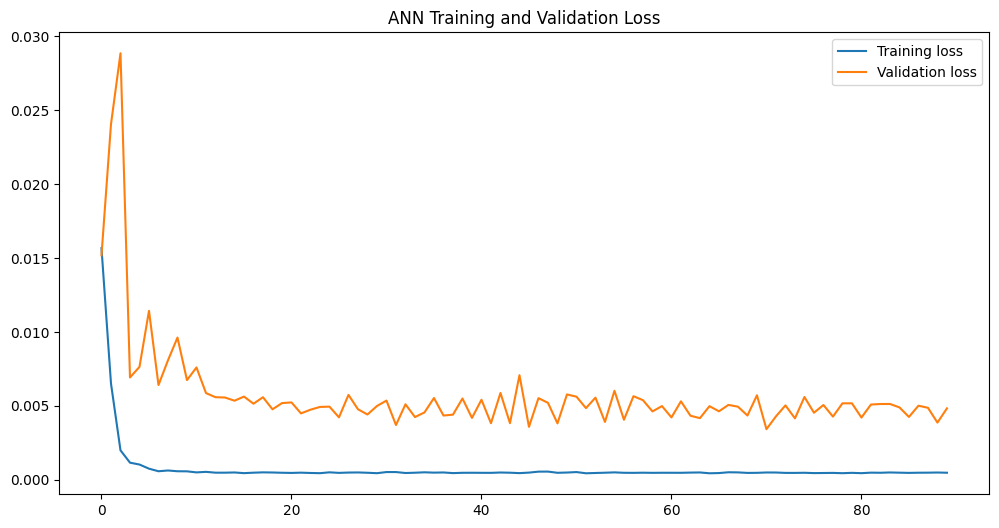

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 15.9650
RMSE: 3.9956
MAE: 2.7366
MAPE: 74.51%
R²: 0.9726


In [ ]:
MSE: 15.9650
RMSE: 3.9956
MAE: 2.7366
MAPE: 74.51%
R²: 0.9726


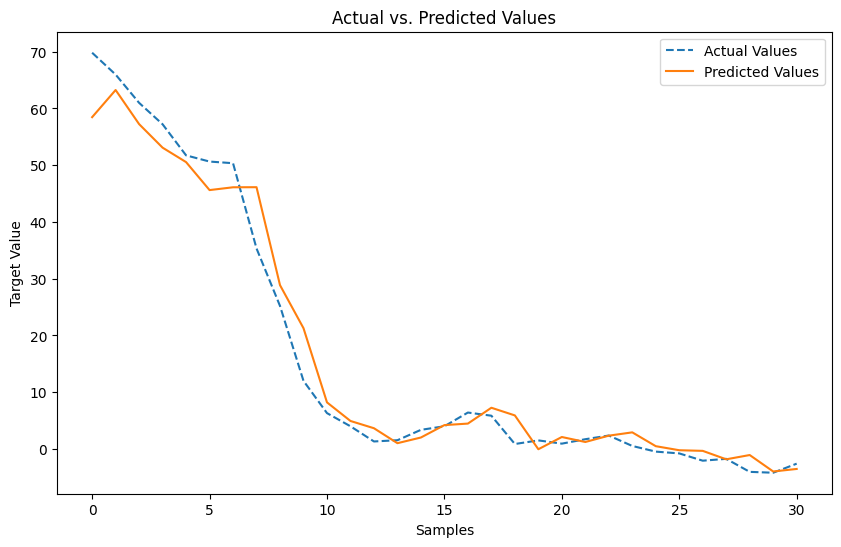

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 3

In [ ]:
data

df=data.copy()
df = df.astype(float)

# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df


# Number of lags to create
lags = 3
lagged_features = create_lagged_features(df, lags)

print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]
train_data
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])
train_data
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

#Best hyperparameters:  {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.45842415177096446, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 40}

import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()

test_predictions_scaled=model.predict(X_test_scaled)
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


## 4

In [ ]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 4
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4'],
      dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-05-31   2.382412         3.672022         4.469678         1.940367   
2000-06-30   6.799835         2.382412         3.672022         4.469678   
2000-07-31  10.139831         6.799835         2.382412         3.672022   
2000-08-31   9.876072        10.139831         6.799835         2.382412   
2000-09-30   8.455851         9.876072        10.139831         6.799835   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

299

In [ ]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,,
2000-05-31,2.382412,3.672022,4.469678,1.940367,0.329139
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239


In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,,
2000-05-31,2.382412,3.672022,4.469678,1.940367,0.329139
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503


In [ ]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,,
2000-05-31,2.382412,3.672022,4.469678,1.940367,0.329139
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503


In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2022-10-31,65.963240
2022-11-30,60.982084
2022-12-31,57.207498
2023-01-31,51.729686
2023-02-28,50.635930
2023-03-31,50.346955
2023-04-30,35.327234
2023-05-31,25.195313
2023-06-30,11.997670


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4'],
      dtype='object')

In [ ]:
ytrain

,Inflation
Date,
2000-05-31,2.382412
2000-06-30,6.799835
2000-07-31,10.139831
2000-08-31,9.876072
2000-09-30,8.455851
...,...
2022-05-31,39.130435
2022-06-30,54.634831
2022-07-31,60.796646


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,
2000-05-31,3.672022,4.469678,1.940367,0.329139
2000-06-30,2.382412,3.672022,4.469678,1.940367
2000-07-31,6.799835,2.382412,3.672022,4.469678
2000-08-31,10.139831,6.799835,2.382412,3.672022
2000-09-30,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...
2022-05-31,29.827089,18.718503,15.097052,14.203317
2022-06-30,39.130435,29.827089,18.718503,15.097052
2022-07-31,54.634831,39.130435,29.827089,18.718503


In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.0459622 , 0.06194354, 0.02208755, 0.        ],
       [0.02567587, 0.04865956, 0.0690269 , 0.04152511],
       [0.09516458, 0.02718269, 0.05422387, 0.10671134],
       ...,
       [0.84763773, 0.63917587, 0.53961388, 0.47393684],
       [0.94456676, 0.89738255, 0.71226688, 0.76023106],
       [1.        , 1.        , 1.        , 1.        ]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,
2000-05-31,0.045962,0.061944,0.022088,0.000000
2000-06-30,0.025676,0.048660,0.069027,0.041525
2000-07-31,0.095165,0.027183,0.054224,0.106711
2000-08-31,0.147705,0.100749,0.030291,0.086154
2000-09-30,0.143556,0.156373,0.112270,0.052918
...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.357570
2022-06-30,0.603744,0.484240,0.333459,0.380604
2022-07-31,0.847638,0.639176,0.539614,0.473937


In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,,
2000-05-31,2.382412,0.045962,0.061944,0.022088,0.000000
2000-06-30,6.799835,0.025676,0.048660,0.069027,0.041525
2000-07-31,10.139831,0.095165,0.027183,0.054224,0.106711
2000-08-31,9.876072,0.147705,0.100749,0.030291,0.086154
2000-09-30,8.455851,0.143556,0.156373,0.112270,0.052918
...,...,...,...,...,...
2022-05-31,39.130435,0.457397,0.299240,0.266251,0.357570
2022-06-30,54.634831,0.603744,0.484240,0.333459,0.380604
2022-07-31,60.796646,0.847638,0.639176,0.539614,0.473937


In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,
2000-05-31,0.045962,0.061944,0.022088,0.000000
2000-06-30,0.025676,0.048660,0.069027,0.041525
2000-07-31,0.095165,0.027183,0.054224,0.106711
2000-08-31,0.147705,0.100749,0.030291,0.086154
2000-09-30,0.143556,0.156373,0.112270,0.052918
...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.357570
2022-06-30,0.603744,0.484240,0.333459,0.380604
2022-07-31,0.847638,0.639176,0.539614,0.473937


In [ ]:
###########

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 09:38:43,544] A new study created in memory with name: no-name-8c65a4f6-2390-4193-bf88-79ea65fea8e5
[I 2025-05-29 09:39:06,356] Trial 0 finished with value: 0.0013671733031515032 and parameters: {'input_units': 80, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 16, 'dropout_rate_0': 0.04322169339417209, 'n_units_1': 128, 'dropout_rate_1': 0.12968025047291237, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 50}. Best is trial 0 with value: 0.0013671733031515032.
[I 2025-05-29 09:39:30,253] Trial 1 finished with value: 0.003772867057705298 and parameters: {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.343509548610174, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 80}. Best is trial 0 with value: 0.0013671733031515032.
[I 2025-05-29 09:39:43,506] Trial 2 finished with value: 0.008950241038110106 and parameters: {'input_units': 96, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 16, 'dropout_rate_0': 0.381471649149

Best hyperparameters:  {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.3995381977150744, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 80}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.3995381977150744, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 80}
Epoch 1/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0164 - mae: 0.0907 - val_loss: 0.0179 - val_mae: 0.0973
Epoch 2/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0117 - mae: 0.0851 - val_loss: 0.0402 - val_mae: 0.1121
Epoch 3/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0051 - mae: 0.0514 - val_loss: 0.0650 - val_mae: 0.1581
Epoch 4/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0060 - mae: 0.0535 - val_loss: 0.0245 - val_mae: 0.0880
Epoch 5/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0031 - mae: 0.0410 - val_loss: 0.0069 - val_mae: 0.0498
Epoch 6/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0038 - mae: 0.0443 - val_loss: 0.0107 - val_mae: 0.0578
Epoch 7/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0028 - mae: 0.0363 - val_loss: 0.0173 - val_mae: 0.0844
Epoc

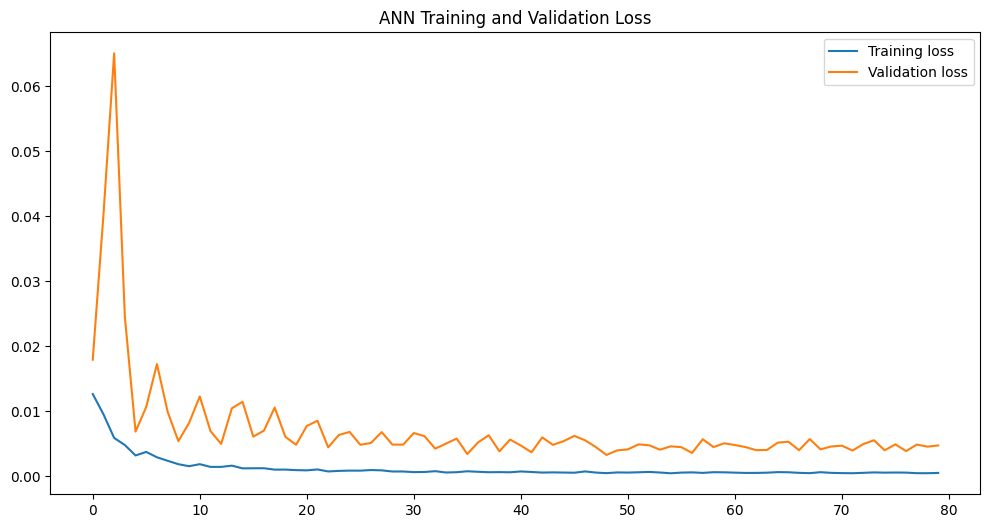

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 13.3126
RMSE: 3.6486
MAE: 2.6022
MAPE: 78.57%
R²: 0.9735


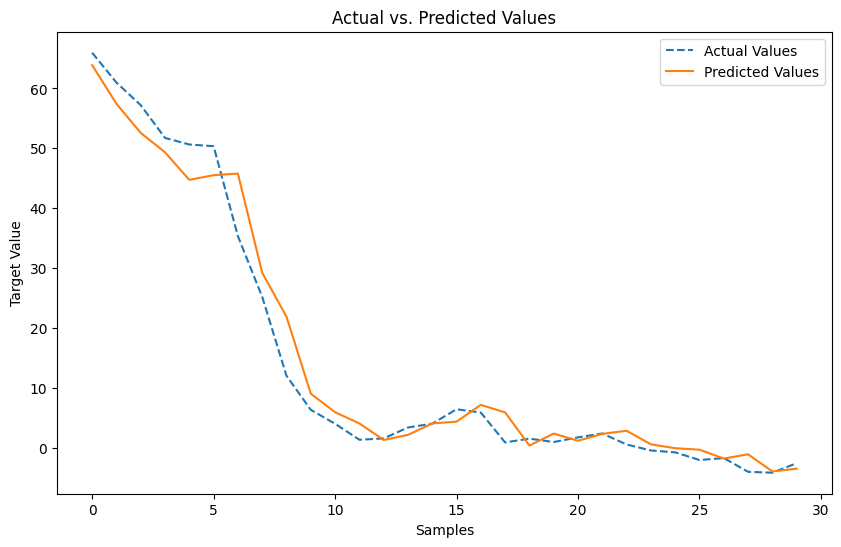

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 5

In [ ]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 5
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5'],
      dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-06-30   6.799835         2.382412         3.672022         4.469678   
2000-07-31  10.139831         6.799835         2.382412         3.672022   
2000-08-31   9.876072        10.139831         6.799835         2.382412   
2000-09-30   8.455851         9.876072        10.139831         6.799835   
2000-10-31   7.794494         8.455851         9.876072        10.139831   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

298

In [ ]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,,
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039


In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,,
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052


In [ ]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,,
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052


In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2022-10-31,65.963240
2022-11-30,60.982084
2022-12-31,57.207498
2023-01-31,51.729686
2023-02-28,50.635930
2023-03-31,50.346955
2023-04-30,35.327234
2023-05-31,25.195313
2023-06-30,11.997670


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5'],
      dtype='object')

In [ ]:
ytrain

,Inflation
Date,
2000-06-30,6.799835
2000-07-31,10.139831
2000-08-31,9.876072
2000-09-30,8.455851
2000-10-31,7.794494
...,...
2022-05-31,39.130435
2022-06-30,54.634831
2022-07-31,60.796646


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,
2000-06-30,2.382412,3.672022,4.469678,1.940367,0.329139
2000-07-31,6.799835,2.382412,3.672022,4.469678,1.940367
2000-08-31,10.139831,6.799835,2.382412,3.672022,4.469678
2000-09-30,9.876072,10.139831,6.799835,2.382412,3.672022
2000-10-31,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...
2022-05-31,29.827089,18.718503,15.097052,14.203317,12.101449
2022-06-30,39.130435,29.827089,18.718503,15.097052,14.203317
2022-07-31,54.634831,39.130435,29.827089,18.718503,15.097052


In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.02567587, 0.04865956, 0.0690269 , 0.03101021, 0.        ],
       [0.09516458, 0.02718269, 0.05422387, 0.09691157, 0.05462169],
       [0.14770471, 0.10074945, 0.03029108, 0.07612859, 0.14036699],
       ...,
       [0.84763773, 0.63917587, 0.53961388, 0.46816569, 0.50064202],
       [0.94456676, 0.89738255, 0.71226688, 0.75760069, 0.62341157],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,
2000-06-30,0.025676,0.048660,0.069027,0.031010,0.000000
2000-07-31,0.095165,0.027183,0.054224,0.096912,0.054622
2000-08-31,0.147705,0.100749,0.030291,0.076129,0.140367
2000-09-30,0.143556,0.156373,0.112270,0.042528,0.113326
2000-10-31,0.121215,0.151980,0.174255,0.157624,0.069607
...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.399089
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.470344
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.500642


In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,,
2000-06-30,6.799835,0.025676,0.048660,0.069027,0.031010,0.000000
2000-07-31,10.139831,0.095165,0.027183,0.054224,0.096912,0.054622
2000-08-31,9.876072,0.147705,0.100749,0.030291,0.076129,0.140367
2000-09-30,8.455851,0.143556,0.156373,0.112270,0.042528,0.113326
2000-10-31,7.794494,0.121215,0.151980,0.174255,0.157624,0.069607
...,...,...,...,...,...,...
2022-05-31,39.130435,0.457397,0.299240,0.266251,0.350522,0.399089
2022-06-30,54.634831,0.603744,0.484240,0.333459,0.373809,0.470344
2022-07-31,60.796646,0.847638,0.639176,0.539614,0.468166,0.500642


In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,
2000-06-30,0.025676,0.048660,0.069027,0.031010,0.000000
2000-07-31,0.095165,0.027183,0.054224,0.096912,0.054622
2000-08-31,0.147705,0.100749,0.030291,0.076129,0.140367
2000-09-30,0.143556,0.156373,0.112270,0.042528,0.113326
2000-10-31,0.121215,0.151980,0.174255,0.157624,0.069607
...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.399089
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.470344
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.500642


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 09:55:28,634] A new study created in memory with name: no-name-2c1f34bd-9a82-443c-89cb-acb9f0c03897
[I 2025-05-29 09:55:38,500] Trial 0 finished with value: 0.021015854179859163 and parameters: {'input_units': 128, 'activation': 'sigmoid', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.32637639438934213, 'n_units_1': 48, 'dropout_rate_1': 0.24860882095193126, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 30}. Best is trial 0 with value: 0.021015854179859163.
[I 2025-05-29 09:56:05,951] Trial 1 finished with value: 0.008383337827399372 and parameters: {'input_units': 128, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.305768001931826, 'n_units_1': 96, 'dropout_rate_1': 0.42142823657826406, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 90}. Best is trial 1 with value: 0.008383337827399372.
[I 2025-05-29 09:56:11,822] Trial 2 finished with value: 0.005474062135908753 and parameters: {'input_units': 64, 'activation': 'tanh', 'num_layers

Best hyperparameters:  {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.21362164603844244, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 80}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.21362164603844244, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 80}
Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0091 - mae: 0.0653 - val_loss: 0.0401 - val_mae: 0.1116
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mae: 0.0469 - val_loss: 0.0257 - val_mae: 0.0946
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - mae: 0.0352 - val_loss: 0.0101 - val_mae: 0.0563
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mae: 0.0334 - val_loss: 0.0125 - val_mae: 0.0636
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mae: 0.0280 - val_loss: 0.0088 - val_mae: 0.0537
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0298 - val_loss: 0.0107 - val_mae: 0.0586
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mae: 0.0307 - val_loss: 0.0092 - val_mae:

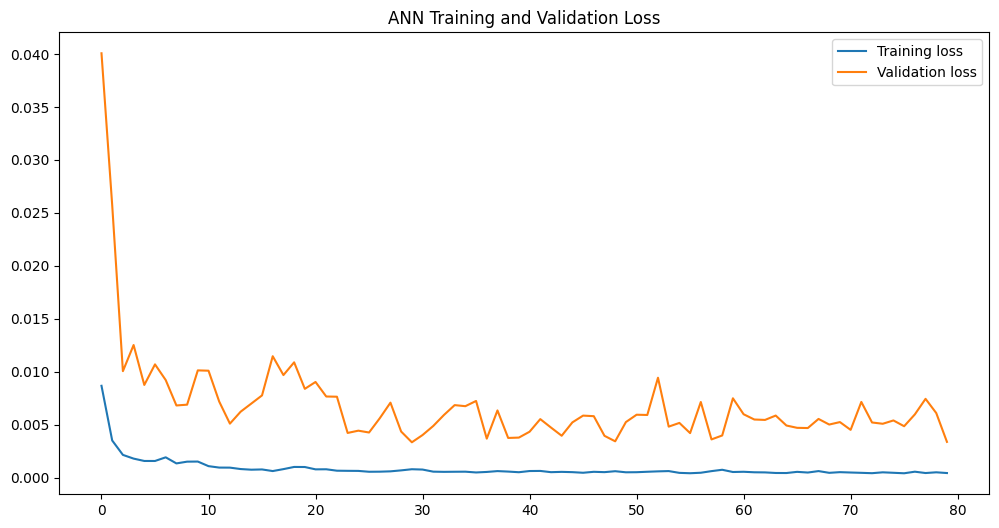

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 22.3831
RMSE: 4.7311
MAE: 3.2408
MAPE: 80.04%
R²: 0.9555


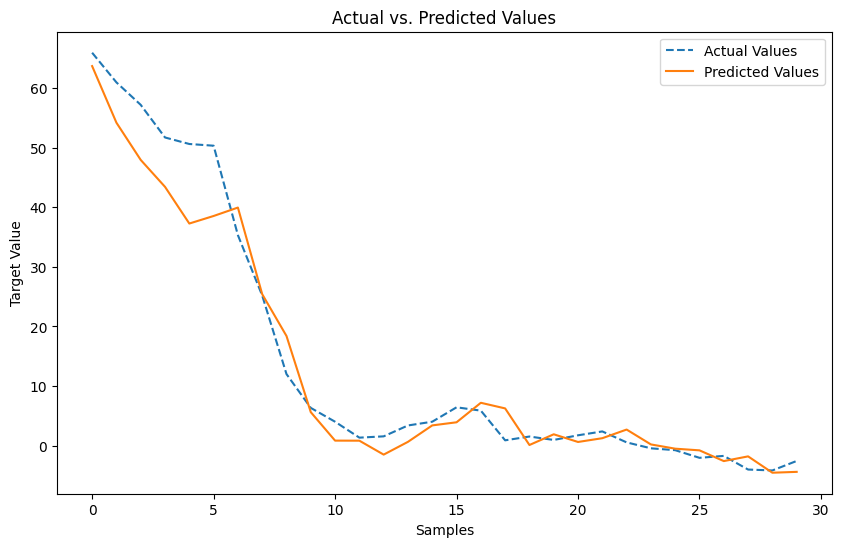

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 6

In [ ]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 6
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6'],
      dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-07-31  10.139831         6.799835         2.382412         3.672022   
2000-08-31   9.876072        10.139831         6.799835         2.382412   
2000-09-30   8.455851         9.876072        10.139831         6.799835   
2000-10-31   7.794494         8.455851         9.876072        10.139831   
2000-11-30   7.559566         7.794494         8.455851         9.876072   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

297

In [ ]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,,
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931


In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,,
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317


In [ ]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,,
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317


In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2022-10-31,65.963240
2022-11-30,60.982084
2022-12-31,57.207498
2023-01-31,51.729686
2023-02-28,50.635930
2023-03-31,50.346955
2023-04-30,35.327234
2023-05-31,25.195313
2023-06-30,11.997670


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6'],
      dtype='object')

In [ ]:
ytrain

,Inflation
Date,
2000-07-31,10.139831
2000-08-31,9.876072
2000-09-30,8.455851
2000-10-31,7.794494
2000-11-30,7.559566
...,...
2022-05-31,39.130435
2022-06-30,54.634831
2022-07-31,60.796646


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,
2000-07-31,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-08-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-09-30,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-10-31,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-11-30,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...
2022-05-31,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767
2022-06-30,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449
2022-07-31,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317


In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.09516458, 0.02718269, 0.05422387, 0.09691157, 0.04093213,
        0.        ],
       [0.14770471, 0.10074945, 0.03029108, 0.07612859, 0.12791907,
        0.05779654],
       [0.14355562, 0.15637297, 0.11227035, 0.04252772, 0.10048643,
        0.14852572],
       ...,
       [0.84763773, 0.63917587, 0.53961388, 0.46816569, 0.49341106,
        0.49768217],
       [0.94456676, 0.89738255, 0.71226688, 0.75760069, 0.61795837,
        0.52974147],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        0.65964691]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,
2000-07-31,0.095165,0.027183,0.054224,0.096912,0.040932,0.000000
2000-08-31,0.147705,0.100749,0.030291,0.076129,0.127919,0.057797
2000-09-30,0.143556,0.156373,0.112270,0.042528,0.100486,0.148526
2000-10-31,0.121215,0.151980,0.174255,0.157624,0.056135,0.119913
2000-11-30,0.110811,0.128328,0.169360,0.244648,0.208057,0.073653
...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.344026
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.422286
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.497682


In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,,
2000-07-31,10.139831,0.095165,0.027183,0.054224,0.096912,0.040932,0.000000
2000-08-31,9.876072,0.147705,0.100749,0.030291,0.076129,0.127919,0.057797
2000-09-30,8.455851,0.143556,0.156373,0.112270,0.042528,0.100486,0.148526
2000-10-31,7.794494,0.121215,0.151980,0.174255,0.157624,0.056135,0.119913
2000-11-30,7.559566,0.110811,0.128328,0.169360,0.244648,0.208057,0.073653
...,...,...,...,...,...,...,...
2022-05-31,39.130435,0.457397,0.299240,0.266251,0.350522,0.390388,0.344026
2022-06-30,54.634831,0.603744,0.484240,0.333459,0.373809,0.462674,0.422286
2022-07-31,60.796646,0.847638,0.639176,0.539614,0.468166,0.493411,0.497682


In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,
2000-07-31,0.095165,0.027183,0.054224,0.096912,0.040932,0.000000
2000-08-31,0.147705,0.100749,0.030291,0.076129,0.127919,0.057797
2000-09-30,0.143556,0.156373,0.112270,0.042528,0.100486,0.148526
2000-10-31,0.121215,0.151980,0.174255,0.157624,0.056135,0.119913
2000-11-30,0.110811,0.128328,0.169360,0.244648,0.208057,0.073653
...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.344026
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.422286
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.497682


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 10:15:49,188] A new study created in memory with name: no-name-5acb623b-4ebe-4564-875a-e1ac0c072692
[I 2025-05-29 10:15:54,064] Trial 0 finished with value: 0.0035926108597777785 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 32, 'dropout_rate_0': 0.39239800993220114, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 10}. Best is trial 0 with value: 0.0035926108597777785.
[I 2025-05-29 10:16:25,786] Trial 1 finished with value: 0.004691875091521069 and parameters: {'input_units': 64, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 48, 'dropout_rate_0': 0.13497717158147005, 'n_units_1': 128, 'dropout_rate_1': 0.23264689880926054, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 100}. Best is trial 0 with value: 0.0035926108597777785.
[I 2025-05-29 10:16:43,920] Trial 2 finished with value: 0.008185674087144434 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 48, 'dropout_rate_0': 0.41484056817

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.2979677539774375, 'n_units_1': 48, 'dropout_rate_1': 0.18436571262684617, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 80}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.2979677539774375, 'n_units_1': 48, 'dropout_rate_1': 0.18436571262684617, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 80}
Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0253 - mae: 0.1121 - val_loss: 0.0709 - val_mae: 0.1821
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0187 - mae: 0.0976 - val_loss: 0.0084 - val_mae: 0.0574
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0050 - mae: 0.0509 - val_loss: 0.0231 - val_mae: 0.0922
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0042 - mae: 0.0458 - val_loss: 0.0120 - val_mae: 0.0632
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044 - mae: 0.0445 - val_loss: 0.0162 - val_mae: 0.0710
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - mae: 0.0372 - val_loss: 0.0078 - val_mae: 0.0514
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0031

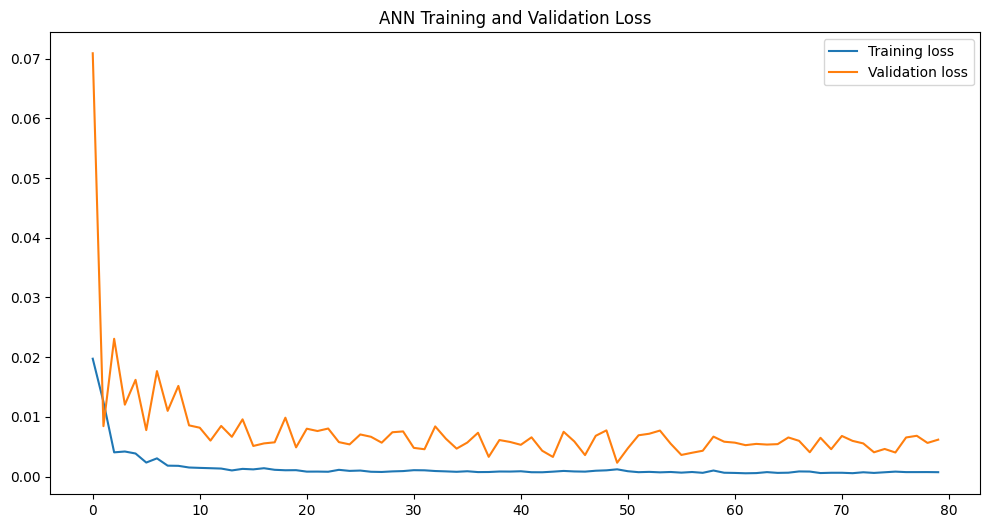

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 28.8971
RMSE: 5.3756
MAE: 3.6513
MAPE: 88.67%
R²: 0.9425


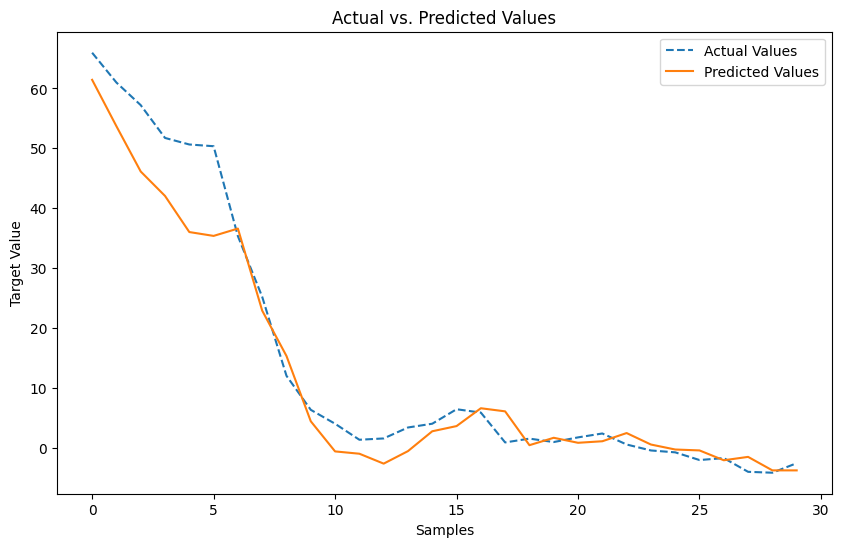

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 7

In [ ]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 7
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7'],
      dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-08-31   9.876072        10.139831         6.799835         2.382412   
2000-09-30   8.455851         9.876072        10.139831         6.799835   
2000-10-31   7.794494         8.455851         9.876072        10.139831   
2000-11-30   7.559566         7.794494         8.455851         9.876072   
2000-12-31  10.836729         7.559566         7.794494         8.455851   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

296

In [ ]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0
Inflation_lag_7,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,,
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069


In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,,
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449


In [ ]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,,
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449


In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2022-10-31,65.963240
2022-11-30,60.982084
2022-12-31,57.207498
2023-01-31,51.729686
2023-02-28,50.635930
2023-03-31,50.346955
2023-04-30,35.327234
2023-05-31,25.195313
2023-06-30,11.997670


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7'],
      dtype='object')

In [ ]:
ytrain

,Inflation
Date,
2000-08-31,9.876072
2000-09-30,8.455851
2000-10-31,7.794494
2000-11-30,7.559566
2000-12-31,10.836729
...,...
2022-05-31,39.130435
2022-06-30,54.634831
2022-07-31,60.796646


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,
2000-08-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-09-30,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-10-31,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-11-30,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-12-31,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...
2022-05-31,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048
2022-06-30,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767
2022-07-31,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449


In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.14770471, 0.10074945, 0.03029108, ..., 0.12791907, 0.04334777,
        0.        ],
       [0.14355562, 0.15637297, 0.11227035, ..., 0.10048643, 0.13546829,
        0.05779654],
       [0.1212147 , 0.15198039, 0.17425452, ..., 0.05613474, 0.1064167 ,
        0.14852572],
       ...,
       [0.84763773, 0.63917587, 0.53961388, ..., 0.49341106, 0.48997908,
        0.42228585],
       [0.94456676, 0.89738255, 0.71226688, ..., 0.61795837, 0.52253002,
        0.49768217],
       [1.        , 1.        , 1.        , ..., 1.        , 0.65442757,
        0.52974147]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,
2000-08-31,0.147705,0.100749,0.030291,0.076129,0.127919,0.043348,0.000000
2000-09-30,0.143556,0.156373,0.112270,0.042528,0.100486,0.135468,0.057797
2000-10-31,0.121215,0.151980,0.174255,0.157624,0.056135,0.106417,0.148526
2000-11-30,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.119913
2000-12-31,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.073653
...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.261497
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.344026
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.422286


In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,,
2000-08-31,9.876072,0.147705,0.100749,0.030291,0.076129,0.127919,0.043348,0.000000
2000-09-30,8.455851,0.143556,0.156373,0.112270,0.042528,0.100486,0.135468,0.057797
2000-10-31,7.794494,0.121215,0.151980,0.174255,0.157624,0.056135,0.106417,0.148526
2000-11-30,7.559566,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.119913
2000-12-31,10.836729,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.073653
...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.261497
2022-06-30,54.634831,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.344026
2022-07-31,60.796646,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.422286


In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,
2000-08-31,0.147705,0.100749,0.030291,0.076129,0.127919,0.043348,0.000000
2000-09-30,0.143556,0.156373,0.112270,0.042528,0.100486,0.135468,0.057797
2000-10-31,0.121215,0.151980,0.174255,0.157624,0.056135,0.106417,0.148526
2000-11-30,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.119913
2000-12-31,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.073653
...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.261497
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.344026
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.422286


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 10:36:29,486] A new study created in memory with name: no-name-ff345a52-fdba-40f0-a78f-19504a3a2393
[I 2025-05-29 10:36:49,736] Trial 0 finished with value: 0.0180773300351575 and parameters: {'input_units': 48, 'activation': 'relu', 'num_layers': 3, 'n_units_0': 64, 'dropout_rate_0': 0.3509583640295225, 'n_units_1': 96, 'dropout_rate_1': 0.47579257773401523, 'n_units_2': 32, 'dropout_rate_2': 0.44130938625903343, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 60}. Best is trial 0 with value: 0.0180773300351575.
[I 2025-05-29 10:37:14,157] Trial 1 finished with value: 0.0011787129187723622 and parameters: {'input_units': 48, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 80, 'dropout_rate_0': 0.37799180298149265, 'n_units_1': 32, 'dropout_rate_1': 0.08099362508961494, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 60}. Best is trial 1 with value: 0.0011787129187723622.
[I 2025-05-29 10:37:25,762] Trial 2 finished with value: 0.018774554086849093 and parameters: {'

Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.2320650290336005, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 70}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.2320650290336005, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 70}
Epoch 1/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0155 - mae: 0.0909 - val_loss: 0.0617 - val_mae: 0.1437
Epoch 2/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0073 - mae: 0.0604 - val_loss: 0.0804 - val_mae: 0.1635
Epoch 3/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0062 - mae: 0.0541 - val_loss: 0.0254 - val_mae: 0.0973
Epoch 4/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0054 - mae: 0.0515 - val_loss: 0.0330 - val_mae: 0.1053
Epoch 5/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0034 - mae: 0.0410 - val_loss: 0.0239 - val_mae: 0.0906
Epoch 6/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0020 - mae: 0.0341 - val_loss: 0.0126 - val_mae: 0.0625
Epoch 7/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0023 - mae: 0.0352 - val_loss: 0.0141 - val_mae: 0.0671
Epoc

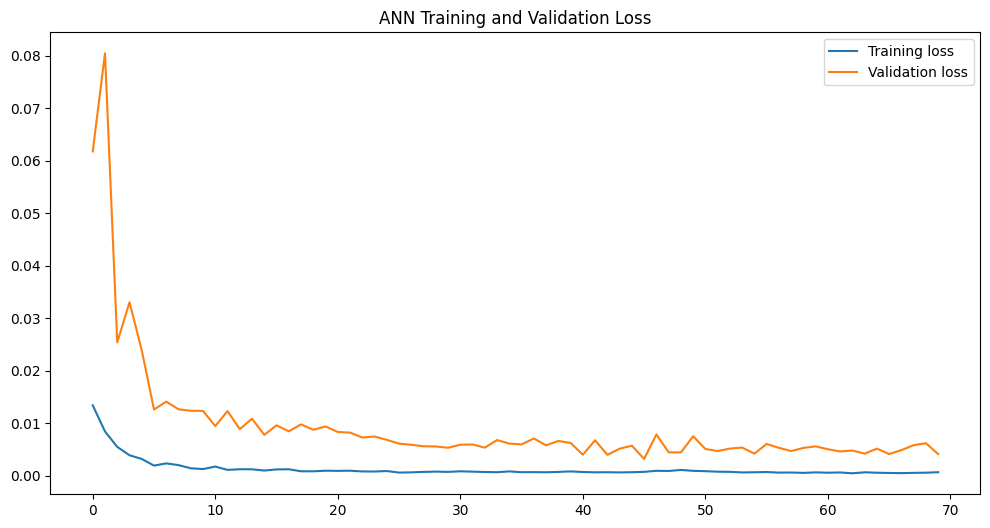

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [ ]:
len(test_predictions)

30

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 15.2808
RMSE: 3.9091
MAE: 2.5525
MAPE: 87.54%
R²: 0.9696


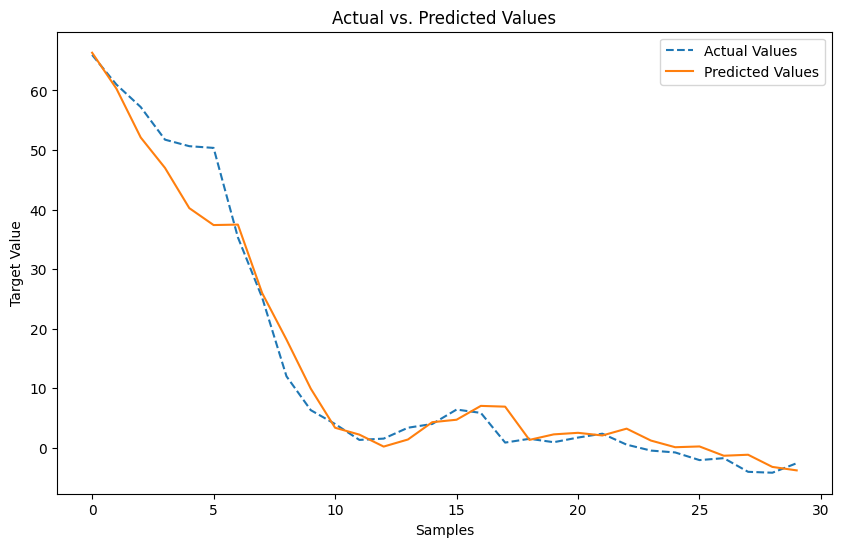

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 8

In [ ]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 8
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8'],
      dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-09-30   8.455851         9.876072        10.139831         6.799835   
2000-10-31   7.794494         8.455851         9.876072        10.139831   
2000-11-30   7.559566         7.794494         8.455851         9.876072   
2000-12-31  10.836729         7.559566         7.794494         8.455851   
2001-01-31  16.170425        10.836729         7.559566         7.794494   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

295

In [ ]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0
Inflation_lag_7,0
Inflation_lag_8,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,,
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037


In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,,
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767


In [ ]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,,
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767


In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2022-10-31,65.963240
2022-11-30,60.982084
2022-12-31,57.207498
2023-01-31,51.729686
2023-02-28,50.635930
2023-03-31,50.346955
2023-04-30,35.327234
2023-05-31,25.195313
2023-06-30,11.997670


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8'],
      dtype='object')

In [ ]:
ytrain

,Inflation
Date,
2000-09-30,8.455851
2000-10-31,7.794494
2000-11-30,7.559566
2000-12-31,10.836729
2001-01-31,16.170425
...,...
2022-05-31,39.130435
2022-06-30,54.634831
2022-07-31,60.796646


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,
2000-09-30,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-10-31,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-11-30,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-12-31,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-01-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...
2022-05-31,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671
2022-06-30,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048
2022-07-31,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767


In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.14355562, 0.15637297, 0.11227035, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.1212147 , 0.15198039, 0.17425452, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.11081115, 0.12832836, 0.16935964, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.84763773, 0.63917587, 0.53961388, ..., 0.48997908, 0.41342656,
        0.34402647],
       [0.94456676, 0.89738255, 0.71226688, ..., 0.52253002, 0.48997908,
        0.42228585],
       [1.        , 1.        , 1.        , ..., 0.65442757, 0.52253002,
        0.49768217]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,
2000-09-30,0.143556,0.156373,0.112270,0.042528,0.100486,0.135468,0.043348,0.000000
2000-10-31,0.121215,0.151980,0.174255,0.157624,0.056135,0.106417,0.135468,0.057797
2000-11-30,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.106417,0.148526
2000-12-31,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.119913
2001-01-31,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.193472
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.261497
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.344026


In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,,
2000-09-30,8.455851,0.143556,0.156373,0.112270,0.042528,0.100486,0.135468,0.043348,0.000000
2000-10-31,7.794494,0.121215,0.151980,0.174255,0.157624,0.056135,0.106417,0.135468,0.057797
2000-11-30,7.559566,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.106417,0.148526
2000-12-31,10.836729,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.119913
2001-01-31,16.170425,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.193472
2022-06-30,54.634831,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.261497
2022-07-31,60.796646,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.344026


In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,
2000-09-30,0.143556,0.156373,0.112270,0.042528,0.100486,0.135468,0.043348,0.000000
2000-10-31,0.121215,0.151980,0.174255,0.157624,0.056135,0.106417,0.135468,0.057797
2000-11-30,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.106417,0.148526
2000-12-31,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.119913
2001-01-31,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.193472
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.261497
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.344026


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 10:55:06,924] A new study created in memory with name: no-name-449e7209-d51b-4684-ac8d-1be837915c77
[I 2025-05-29 10:55:23,851] Trial 0 finished with value: 0.004097318055573851 and parameters: {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.054127802261309144, 'optimizer': 'SGD', 'batch_size': 16, 'epochs': 40}. Best is trial 0 with value: 0.004097318055573851.
[I 2025-05-29 10:55:29,675] Trial 1 finished with value: 0.002713165630120784 and parameters: {'input_units': 128, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 128, 'dropout_rate_0': 0.4316204997011849, 'n_units_1': 64, 'dropout_rate_1': 0.1760787263338333, 'n_units_2': 48, 'dropout_rate_2': 0.4124745656313035, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 10}. Best is trial 1 with value: 0.002713165630120784.
[I 2025-05-29 10:56:03,708] Trial 2 finished with value: 0.005007167282747105 and parameters: {'input_units': 128, 'activation': 'relu', 'num_lay

Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.1055579447617341, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 90}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.1055579447617341, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 90}
Epoch 1/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0118 - mae: 0.0736 - val_loss: 0.0366 - val_mae: 0.1076
Epoch 2/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0498 - val_loss: 0.0213 - val_mae: 0.0821
Epoch 3/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - mae: 0.0318 - val_loss: 0.0146 - val_mae: 0.0680
Epoch 4/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mae: 0.0338 - val_loss: 0.0148 - val_mae: 0.0687
Epoch 5/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - mae: 0.0339 - val_loss: 0.0093 - val_mae: 0.0562
Epoch 6/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mae: 0.0276 - val_loss: 0.0115 - val_mae: 0.0601
Epoch 7/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - mae: 0.0287 - val_loss: 0.0109 - val_mae: 0

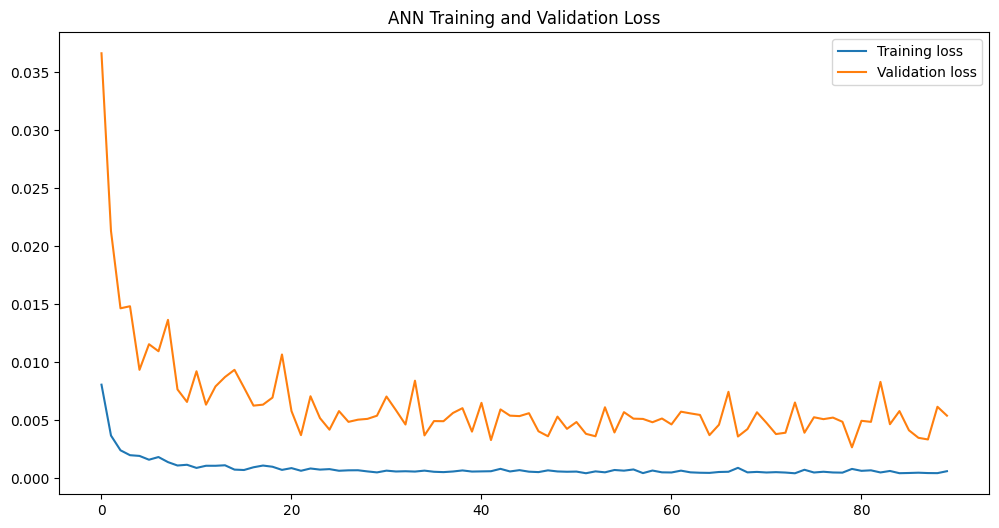

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [ ]:
len(test_predictions)

30

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 52.6143
RMSE: 7.2536
MAE: 4.4812
MAPE: 88.94%
R²: 0.8954


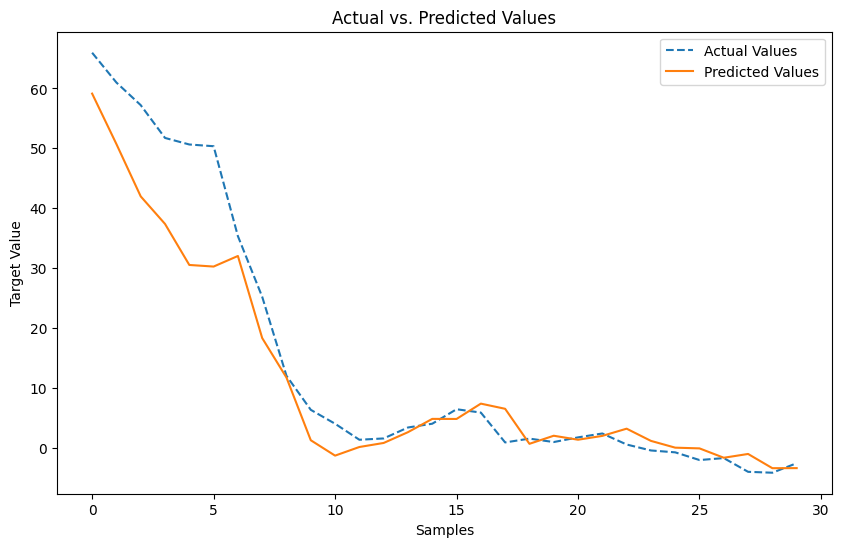

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 9

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 9
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9'],
      dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-10-31   7.794494         8.455851         9.876072        10.139831   
2000-11-30   7.559566         7.794494         8.455851         9.876072   
2000-12-31  10.836729         7.559566         7.794494         8.455851   
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

294

In [ ]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0
Inflation_lag_7,0
Inflation_lag_8,0
Inflation_lag_9,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,,
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795,5.857520
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060


In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,,
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048


In [ ]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,,
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048


In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2022-10-31,65.963240
2022-11-30,60.982084
2022-12-31,57.207498
2023-01-31,51.729686
2023-02-28,50.635930
2023-03-31,50.346955
2023-04-30,35.327234
2023-05-31,25.195313
2023-06-30,11.997670


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9'],
      dtype='object')

In [ ]:
ytrain

,Inflation
Date,
2000-10-31,7.794494
2000-11-30,7.559566
2000-12-31,10.836729
2001-01-31,16.170425
2001-02-28,16.618124
...,...
2022-05-31,39.130435
2022-06-30,54.634831
2022-07-31,60.796646


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,
2000-10-31,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-11-30,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-12-31,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-01-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-02-28,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...
2022-05-31,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275
2022-06-30,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671
2022-07-31,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048


In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.1212147 , 0.15198039, 0.17425452, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.11081115, 0.12832836, 0.16935964, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.1071156 , 0.11731426, 0.14300296, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.84763773, 0.63917587, 0.53961388, ..., 0.41342656, 0.33396706,
        0.26149712],
       [0.94456676, 0.89738255, 0.71226688, ..., 0.48997908, 0.41342656,
        0.34402647],
       [1.        , 1.        , 1.        , ..., 0.52253002, 0.48997908,
        0.42228585]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,
2000-10-31,0.121215,0.151980,0.174255,0.157624,0.056135,0.106417,0.135468,0.043348,0.000000
2000-11-30,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.106417,0.135468,0.057797
2000-12-31,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.106417,0.148526
2001-01-31,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.119913
2001-02-28,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.202784
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.193472
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.261497


In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,,
2000-10-31,7.794494,0.121215,0.151980,0.174255,0.157624,0.056135,0.106417,0.135468,0.043348,0.000000
2000-11-30,7.559566,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.106417,0.135468,0.057797
2000-12-31,10.836729,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.106417,0.148526
2001-01-31,16.170425,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.119913
2001-02-28,16.618124,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.202784
2022-06-30,54.634831,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.193472
2022-07-31,60.796646,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.261497


In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,
2000-10-31,0.121215,0.151980,0.174255,0.157624,0.056135,0.106417,0.135468,0.043348,0.000000
2000-11-30,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.106417,0.135468,0.057797
2000-12-31,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.106417,0.148526
2001-01-31,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.119913
2001-02-28,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.202784
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.193472
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.261497


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 11:18:40,350] A new study created in memory with name: no-name-ac0e3194-9255-489b-99b5-eb9c03758c05
[I 2025-05-29 11:18:52,563] Trial 0 finished with value: 0.008462014514952898 and parameters: {'input_units': 80, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 64, 'dropout_rate_0': 0.2360811349611024, 'n_units_1': 16, 'dropout_rate_1': 0.40954627825131856, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 30}. Best is trial 0 with value: 0.008462014514952898.
[I 2025-05-29 11:19:04,385] Trial 1 finished with value: 0.003558048594277352 and parameters: {'input_units': 32, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.21168960729959824, 'n_units_1': 64, 'dropout_rate_1': 0.05203572528061945, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 30}. Best is trial 1 with value: 0.003558048594277352.
[I 2025-05-29 11:19:44,979] Trial 2 finished with value: 0.01897578192874789 and parameters: {'input_units': 48, 'activation': 'sigmoid', 'num_lay

Best hyperparameters:  {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.3433388445823001, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 90}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.3433388445823001, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 90}
Epoch 1/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0179 - mae: 0.0960 - val_loss: 0.0672 - val_mae: 0.1481
Epoch 2/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0124 - mae: 0.0722 - val_loss: 0.0119 - val_mae: 0.0641
Epoch 3/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0083 - mae: 0.0620 - val_loss: 0.0115 - val_mae: 0.0706
Epoch 4/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0042 - mae: 0.0470 - val_loss: 0.0027 - val_mae: 0.0330
Epoch 5/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0056 - mae: 0.0537 - val_loss: 0.0082 - val_mae: 0.0581
Epoch 6/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0050 - mae: 0.0475 - val_loss: 0.0071 - val_mae: 0.0474
Epoch 7/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0034 - mae: 0.0371 - val_loss: 0.0134 - val_mae: 0.0709
Epoch

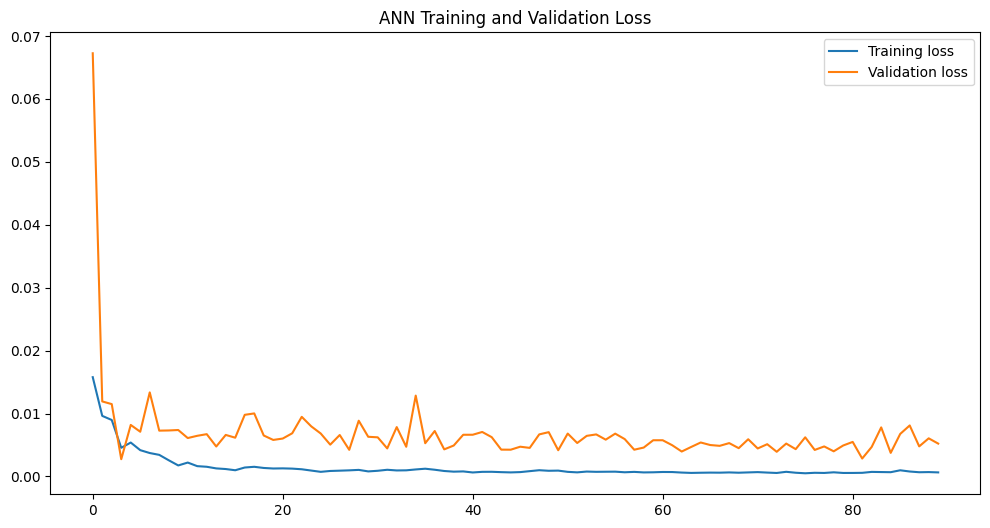

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [ ]:
len(test_predictions)

30

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 32.2381
RMSE: 5.6779
MAE: 4.1151
MAPE: 99.98%
R²: 0.9359


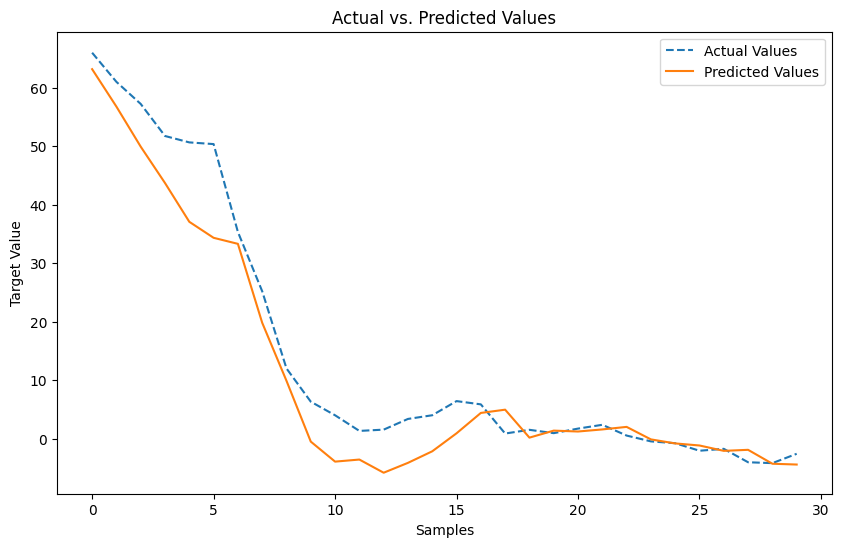

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()